In [73]:
import sys
import statistics
from pathlib import Path
sys.path.append(str(Path.cwd().parent / "src"))
import matplotlib.pyplot as plt
import torch
import pickle
from config import CHECKPOINTS, PROCESSED_PNGS

In [74]:
# how many tangrams did I find?

import os
cpt = sum([len(files) for r, d, files in os.walk(PROCESSED_PNGS)])
cpt

471

In [75]:
comp_checkpoints = CHECKPOINTS / 'comp'
comp_checkpoint_files = sorted(comp_checkpoints.glob('checkpoint_batch_*.pkl'))
comp_last_checkpoint = comp_checkpoint_files[-1]

with open(comp_last_checkpoint, 'rb') as f:
    comp_checkpoint = pickle.load(f)
    comp_image_sets = comp_checkpoint['sets']

In [76]:
noncomp_checkpoints = CHECKPOINTS / 'noncomp'
noncomp_checkpoint_files = sorted(noncomp_checkpoints.glob('checkpoint_batch_*.pkl'))
noncomp_last_checkpoint = noncomp_checkpoint_files[-1]

with open(noncomp_last_checkpoint, 'rb') as f:
    noncomp_checkpoint = pickle.load(f)
    noncomp_image_sets = noncomp_checkpoint['sets']

We now need to decide how we're going to shave off chunks of this tangram space for use in the experiment. First, what do the similarity distributions look like?

In [77]:
comp_pairwise_sims = []
for item in comp_image_sets.values():
    comp_pairwise_sims.append(item.get_pairwise_embeddings())

comp_pairwise_sims = torch.concat(comp_pairwise_sims)

noncomp_pairwise_sims = []
for item in noncomp_image_sets.values():
    noncomp_pairwise_sims.append(item.get_pairwise_embeddings())

noncomp_pairwise_sims = torch.concat(noncomp_pairwise_sims)

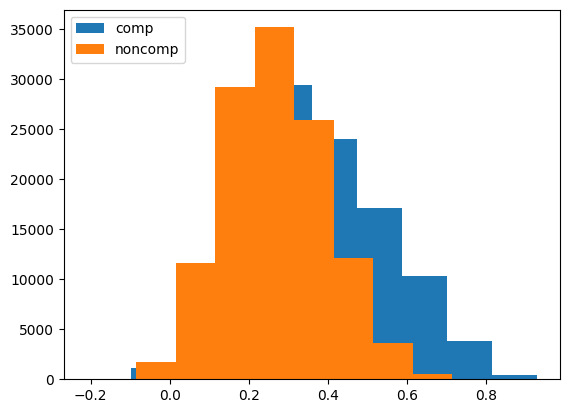

In [78]:
plt.hist(comp_pairwise_sims, label = "comp")
plt.hist(noncomp_pairwise_sims, label = "noncomp")
plt.legend(loc="upper left")

This model generates fewer highly similar embeddings. One problem is that each shape space has a range of similarities that span a range of similarities. ie:

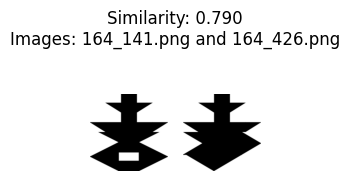

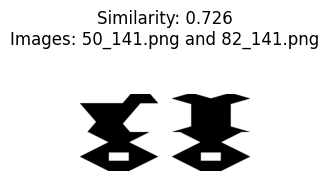

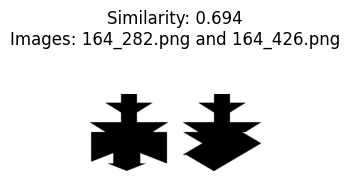

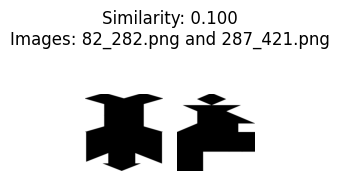

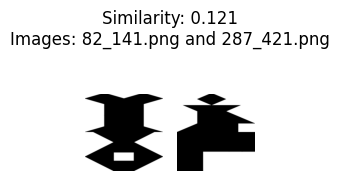

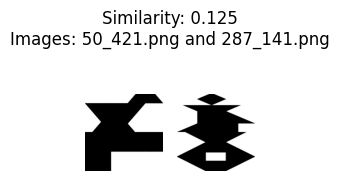

In [79]:
comp_image_sets[35].display_ranked_pairs(n_pairs = 3, figsize=(2,2))
comp_image_sets[35].display_ranked_pairs(n_pairs = 3, figsize=(2,2), reverse = True)

In [80]:
torch.median(comp_pairwise_sims).item()

0.3400660455226898

For example, the median similarity for compositional shapes is ~0.3425 for this set of 500 shapes, but if we look at the histogram of max pairwise similarities...

Text(0.5, 1.0, 'Hist of max similarities (comp)')

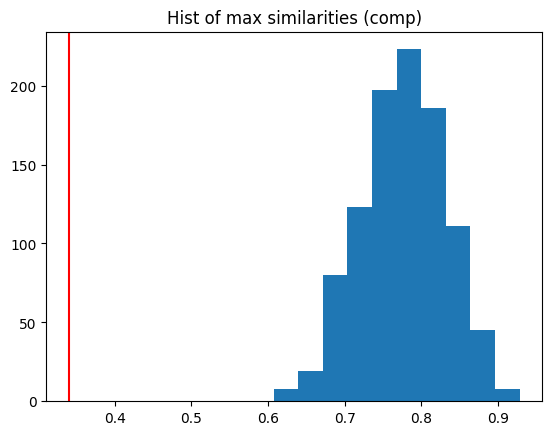

In [81]:
max_similarities_comp = [
        comp_image_sets[set].get_summary_stats()['max_similarity'] 
        for set in comp_image_sets
    ]

fig1, ax1 = plt.subplots()
ax1.hist(max_similarities_comp)
ax1.axvline(x=torch.median(comp_pairwise_sims).item(), color='r')
ax1.set_title("Hist of max similarities (comp)")

Instead, we can look at the median of the x values (0.77) and discard any tangram sets where the max similarity is greater than or equal to this median max similarity. 

Text(0.5, 1.0, 'Hist of max similarities (comp)')

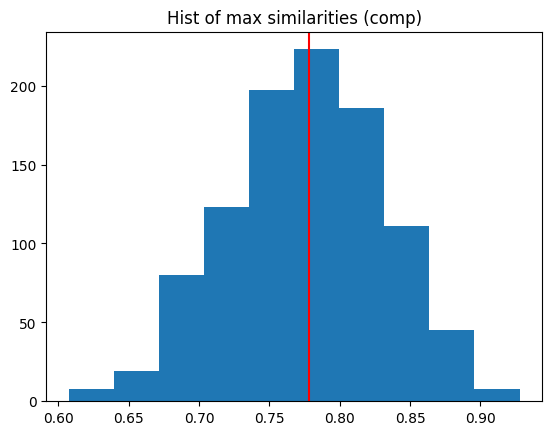

In [82]:
fig1, ax1 = plt.subplots()
ax1.hist(max_similarities_comp)
ax1.axvline(x=statistics.median(max_similarities_comp), color='r')
ax1.set_title("Hist of max similarities (comp)")

Text(0.5, 1.0, 'Hist of max similarities (noncomp)')

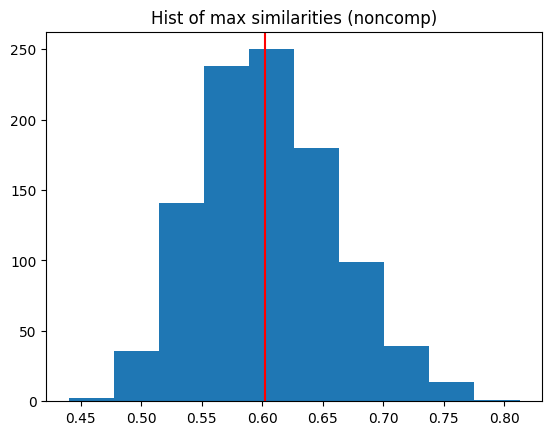

In [83]:
# do the same for noncomp
max_similarities_noncomp = [
        noncomp_image_sets[set].get_summary_stats()['max_similarity'] 
        for set in noncomp_image_sets
    ]

fig1, ax1 = plt.subplots()
ax1.hist(max_similarities_noncomp)
ax1.axvline(x=statistics.median(max_similarities_noncomp), color='r')
ax1.set_title("Hist of max similarities (noncomp)")

In [84]:
median_max_noncomp = statistics.median(max_similarities_noncomp)
median_max_comp = statistics.median(max_similarities_comp)

In [85]:
median_max_comp

0.7784893810749054

In [86]:
rejected_comp_sets = []
kept_comp_sets = []
for set_id, image_set in comp_image_sets.items():
    summary = image_set.get_summary_stats()
    if summary['max_similarity'] >= median_max_comp:
        rejected_comp_sets.append(set_id)
    else:
        kept_comp_sets.append(set_id)

In [87]:
rejected_noncomp_sets = []
kept_noncomp_sets = []
for set_id, image_set in noncomp_image_sets.items():
    summary = image_set.get_summary_stats()
    if summary['max_similarity'] >= median_max_noncomp:
        rejected_noncomp_sets.append(set_id)
    else:
        kept_noncomp_sets.append(set_id)

In [88]:
len(kept_comp_sets)

500

In [89]:
import random

Found 500 sets with max similarity < 0.7784893810749054


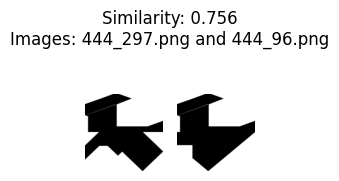

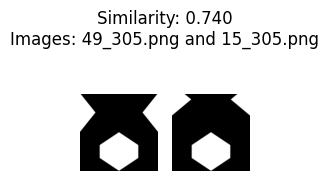

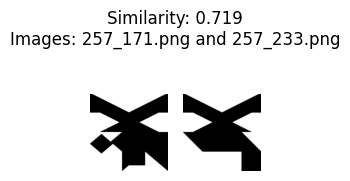

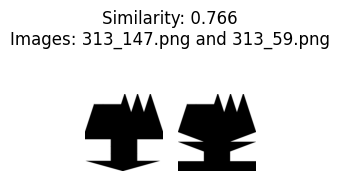

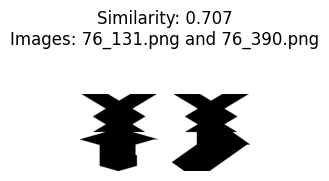

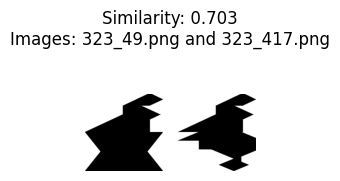

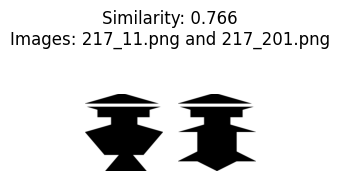

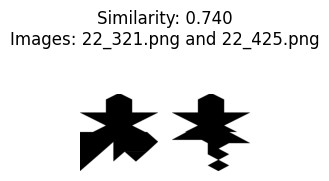

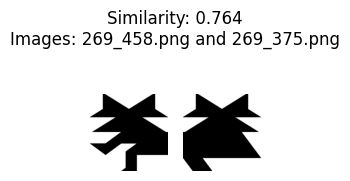

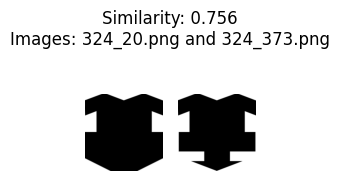

In [90]:
print(f"Found {len(kept_comp_sets)} sets with max similarity < {median_max_comp}")

# Look at each set's most similar pairs
for set_id in random.sample(kept_comp_sets, 10):
    shapeset = comp_image_sets[set_id]
    shapeset.display_ranked_pairs(n_pairs=1, figsize = (2,2))

Found 500 sets with max similarity >= 0.7784893810749054


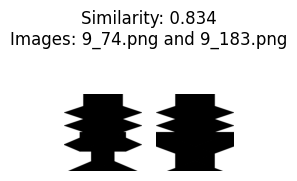

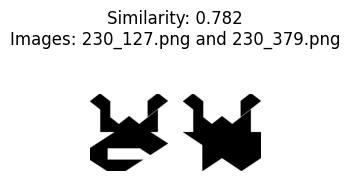

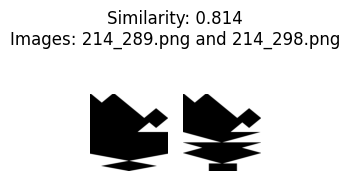

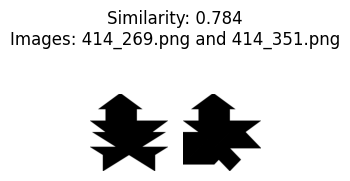

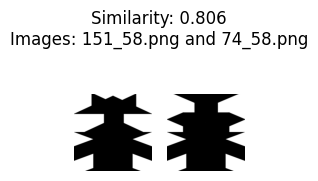

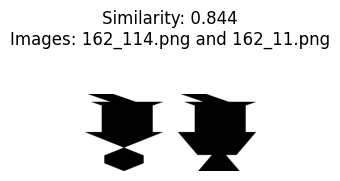

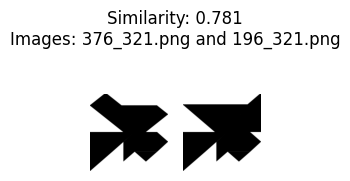

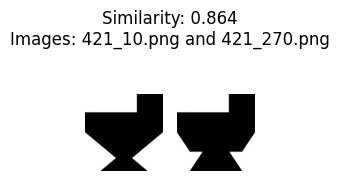

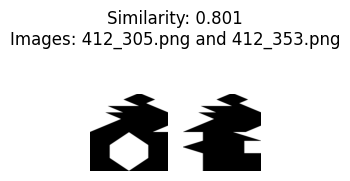

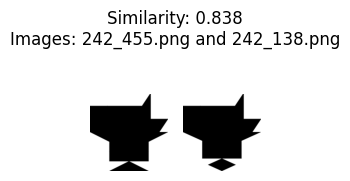

In [91]:
print(f"Found {len(rejected_comp_sets)} sets with max similarity >= {median_max_comp}")

# Look at each set's most similar pairs
for set_id in random.sample(rejected_comp_sets, 10):
    shapeset = comp_image_sets[set_id]
    shapeset.display_ranked_pairs(n_pairs=1, figsize = (2,2))

Found 500 sets with median similarity > 0.602084755897522


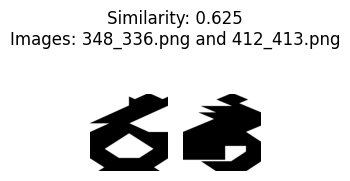

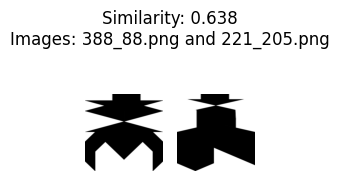

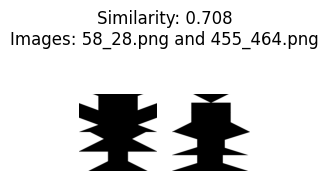

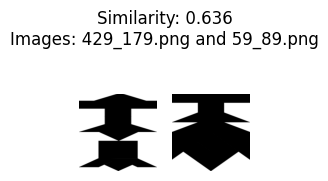

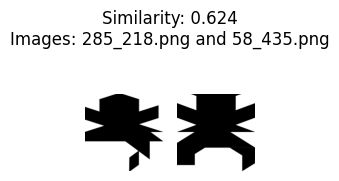

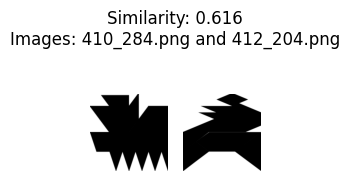

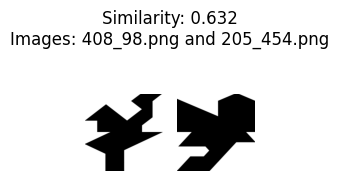

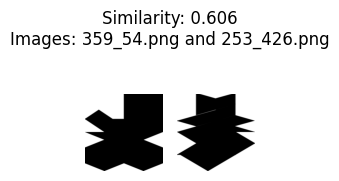

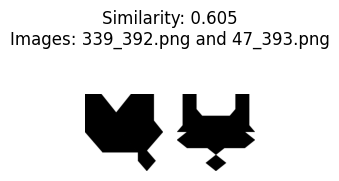

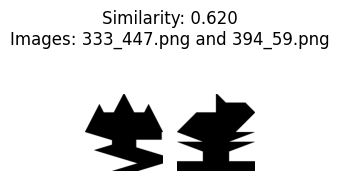

In [92]:
print(f"Found {len(rejected_noncomp_sets)} sets with median similarity > {median_max_noncomp}")

# Look at each set's most similar pairs
for set_id in random.sample(rejected_noncomp_sets, 10):
    shapeset = noncomp_image_sets[set_id]
    shapeset.display_ranked_pairs(n_pairs=1, figsize = (2,2))

Found 500 sets with median similarity <= 0.602084755897522


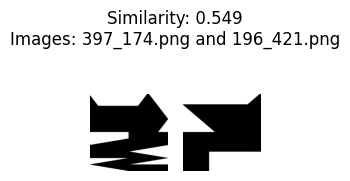

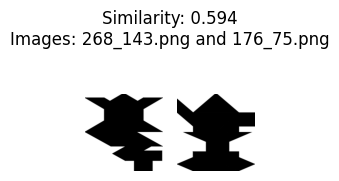

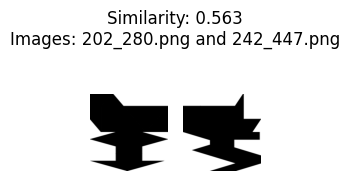

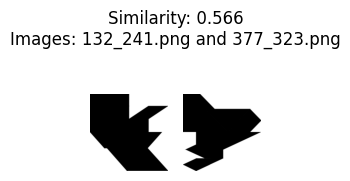

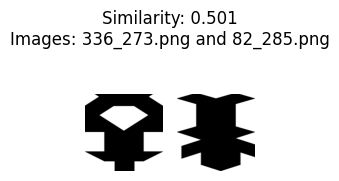

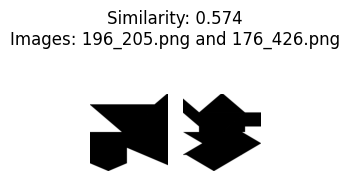

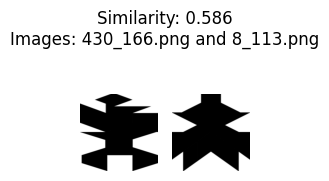

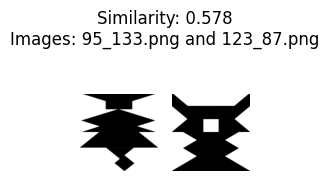

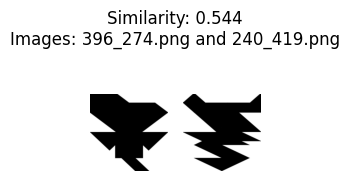

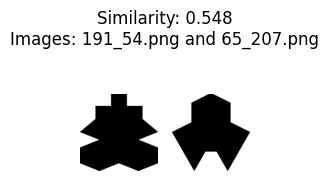

In [93]:
print(f"Found {len(kept_noncomp_sets)} sets with median similarity <= {median_max_noncomp}")

# Look at each set's most similar pairs
for set_id in random.sample(kept_noncomp_sets, 10):
    shapeset = noncomp_image_sets[set_id]
    shapeset.display_ranked_pairs(n_pairs=1, figsize = (2,2))

In [94]:
#print(kept_comp_sets)
kept_max_similarities_noncomp = [
        noncomp_image_sets[set].get_summary_stats()['max_similarity'] 
        for set in kept_noncomp_sets
    ]

kept_max_similarities_comp = [
        noncomp_image_sets[set].get_summary_stats()['max_similarity'] 
        for set in kept_comp_sets
    ]

In [95]:
print("noncomp: ", statistics.mean(kept_max_similarities_noncomp))
print("comp: ", statistics.mean(kept_max_similarities_comp))

noncomp:  0.5603705607652664
comp:  0.6042185052037239


In [96]:
print("noncomp min, max")
print("min: ", min(kept_max_similarities_noncomp))
print("max: ", max(kept_max_similarities_noncomp))

noncomp min, max
min:  0.4401632249355316
max:  0.6020057201385498


In [97]:
print("comp min, max")
print("min: ", min(kept_max_similarities_comp))
print("max: ", max(kept_max_similarities_comp))

comp min, max
min:  0.4654404819011688
max:  0.7654263377189636


kept_max_similarities_noncomp